In [1]:
!git clone https://github.com/AvonYangXX1/DreamWalker.git
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

Cloning into 'DreamWalker'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 221 (delta 0), reused 8 (delta 0), pack-reused 211
Receiving objects: 100% (221/221), 816.76 MiB | 16.96 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (82/82), done.


In [2]:
def read_cv_data(i):
    path = "DreamWalker/data/processed_data/AMP"
    pep_train = np.load(f"{path}/pep_train_{i}.npz")["data"].astype("float32")
    target_train = np.load(f"{path}/target_train_{i}.npz")["data"].astype("float32")
    label_train = np.load(f"{path}/label_train_{i}.npz")["data"].astype("float32")
    pep_val = np.load(f"{path}/pep_val_{i}.npz")["data"].astype("float32")
    target_val = np.load(f"{path}/target_val_{i}.npz")["data"].astype("float32")
    label_val = np.load(f"{path}/label_val_{i}.npz")["data"].astype("float32")
    pep_train = tf.one_hot(pep_train, depth=43)
    pep_val = tf.one_hot(pep_val, depth=43)
    return pep_train, target_train, label_train, pep_val, target_val, label_val

In [3]:
def visualize_pred(pred, label):
    meta = LinearRegression()
    meta.fit(pred, label)
    line = meta.predict(pred)
    fig, axs = plt.subplots(1,1)
    axs.scatter(pred, label, marker="+", color="royalblue", alpha=0.5)
    axs.plot(pred, line, color="black")
    axs.set_xlabel("Predicted")
    axs.set_ylabel("True")

In [31]:
def create_classifier():
    path = "DreamWalker/model_weights"
    vocab_size = 3982
    length = 19
    encoder_inputs = tf.keras.layers.Input(shape=(1024,))
    x = tf.keras.layers.RepeatVector(length, name="RepeatVector")(encoder_inputs)
    x = tf.keras.layers.GRU(1024, return_sequences=True, dropout=0.2, name="GRU0")(x)
    x = tf.keras.layers.GRU(1024, return_sequences=True, dropout=0.2, name="GRU1")(x)
    x = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
    classifier = tf.keras.models.Model(encoder_inputs,x)
    classifier.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                       loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    for i, layer in enumerate(classifier.layers):
        weights = np.load(f"{path}/ClassifierWeights/layer_{i}_weights.npz", allow_pickle=True)["weights"]
        layer.set_weights(weights)
        layer.trainable = False
    return classifier

def create_model(seq_len=40):
    inputs0 = tf.keras.layers.Input((seq_len, 43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((1024,),name="BacteriaInput")
    # Extract Peptide Features
    x0 = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x0 = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x0) # Just two layers work better
    x0 = tf.keras.layers.Flatten(name="Flatten_CNN")(x0)
    x0 = tf.keras.layers.Dense(512, activation="relu", name="CNN_Dense0")(x0)

    # Target Marker Gene Representation
    classifier = create_classifier()
    MarkerRepresentModule = tf.keras.models.Model(classifier.layers[0].input,
                                                  classifier.layers[-1].output,
                                                  name="ClassifierModule")
    x1 = MarkerRepresentModule(inputs1)
    x1 = tf.keras.layers.Conv1D(128, 4, activation='relu', name="Conv1D_GRU0")(x1)
    x1 = tf.keras.layers.Flatten(name="Flatten_GRU")(x1)
    x1 = tf.keras.layers.Dense(512, activation="relu", name="GRU_DenseLast")(x1) # mimic the previous version

    # FCN
    x = tf.keras.layers.Concatenate(axis=1, name="Concat_FCN")([x0, x1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="FCN_Dense0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="FCN_Dense1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation=tf.keras.activations.softplus, name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="Oracle")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[tf.keras.metrics.R2Score()])
    return model

In [10]:
loss = []
r2 = []
for i in range(5):
    pep_train, target_train, label_train, pep_val, target_val, label_val = read_cv_data(i)
    model = create_model()
    model.fit([pep_train, target_train], label_train, batch_size=32, verbose=0, epochs=20,
              validation_data=([pep_val, target_val], label_val))
    pred = model.predict([pep_val, target_val], verbose=0)
    loss.append(mean_absolute_error(label_val, pred))
    r2.append(r2_score(label_val, pred))
    print(f"Fold {i}: Loss={loss[i]:4f}; R2={r2[i]:4f}")
    del pep_train, target_train, label_train, pep_val, target_val, label_val
print(f"Mean: Loss={np.mean(loss):4f}; R2={np.mean(r2):4f}")

Fold 0: Loss=0.978042; R2=0.509316
Fold 1: Loss=0.965754; R2=0.492051
Fold 2: Loss=0.958433; R2=0.512760
Fold 3: Loss=1.008537; R2=0.476734
Fold 4: Loss=0.991424; R2=0.474579
Mean: Loss=0.980438; R2=0.493088


In [11]:
path = "DreamWalker/data/processed_data/AMP"
pep_train = np.load(f"{path}/pep_cv.npz")["data"].astype("float32")
target_train = np.load(f"{path}/target_cv.npz")["data"].astype("float32")
label_train = np.load(f"{path}/label_cv.npz")["data"].astype("float32")
pep_test = np.load(f"{path}/pep_test.npz")["data"].astype("float32")
target_test = np.load(f"{path}/target_test.npz")["data"].astype("float32")
label_test = np.load(f"{path}/label_test.npz")["data"].astype("float32")
pep_train = tf.one_hot(pep_train, depth=43)
pep_test = tf.one_hot(pep_test, depth=43)

In [12]:
model = create_model()
model.fit([pep_train, target_train], label_train, batch_size=32, verbose=0, epochs=20)
pred = model.predict([pep_test, target_test], verbose=0)
mae = mean_absolute_error(label_test, pred)
r2 = r2_score(label_test, pred)
print(f"MAE={mae:4f}; R2={r2:4f}")

MAE=0.960373; R2=0.501016


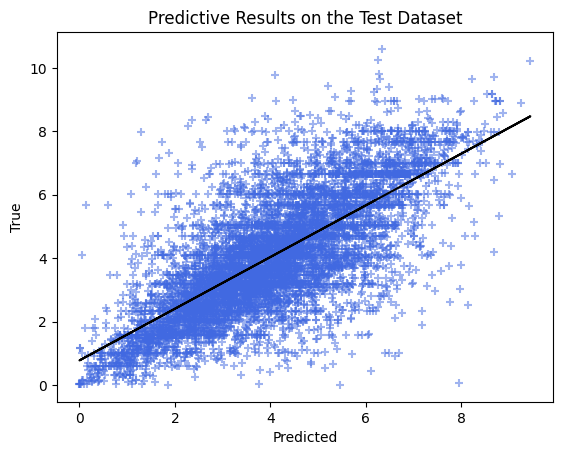

In [48]:
meta = LinearRegression()
meta.fit(pred, label_test)
line = meta.predict(pred)
fig, axs = plt.subplots(1,1)
axs.scatter(pred, label_test, marker="+", color="royalblue", alpha=0.5)
axs.plot(pred, line, color="black")
axs.set_xlabel("Predicted")
axs.set_ylabel("True")
axs.set_title("Predictive Results on the Test Dataset")
plt.savefig("oracle_performance.png")

In [14]:
pep = np.load(f"{path}/pep_whole.npz")["data"].astype("float32")
target = np.load(f"{path}/target_whole.npz")["data"].astype("float32")
label = np.load(f"{path}/label_whole.npz")["data"].astype("float32")
pep = tf.one_hot(pep, depth=43)

In [46]:
model = create_model()
model.fit([pep, target], label, batch_size=32, verbose=0, epochs=20)

In [47]:
path = "drive/MyDrive/DreamWalker/model_weights/OracleWeights"
for i, layer in enumerate(model.layers):
    param = layer.get_weights()
    if len(param) == 0:
        continue
    weights = param[0]
    biases = param[1]
    np.savez_compressed(f'{path}/layer_{i}_weights', weights=weights)
    np.savez_compressed(f'{path}/layer_{i}_biases', biases=biases)